In [213]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms,utils
import time 


In [214]:
sys.path.append("lib/")
import model
import data_handle

In [215]:
import pickle as pk

MODELNAME = 'Alpha20_8Head_128Hidden_Start_end'
EPOCH = 5
META = f"loss_log/{MODELNAME}"
with open(META,"rb") as f :
    meta = pk.load(f)
train_loss_log = meta['train_log']
val_loss_log = meta['val_log']
meta_data = meta['meta']

In [216]:
input_dim = meta_data['input_dim']  # Number of amino acids (replace with your actual input dimension)
output_dim = meta_data['output_dim']  # Binary labels
hidden_dim = meta_data['hidden_dim']
num_layers = meta_data['num_layers']
num_heads = meta_data['num_heads']
latest_model = f'Model/{MODELNAME}/{MODELNAME}_{EPOCH}.pth'
TRAIN = "data/ATP_train.txt"
TEST = "data/ATP_test.txt"

In [217]:
test_set = data_handle.ProteinDataset(TEST)
test_loader = data.DataLoader(test_set, batch_size=1, shuffle=False)

In [218]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [219]:
if torch.cuda.is_available():
    # Initialize CUDA device
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [220]:
def test(model,data_loader,criterion):
    model.eval()
    total_loss = 0
    N = len(data_loader.dataset)
    #For Recall/f1/accuaracy
    tp = 0
    fp = 0 
    tn = 0
    fn = 0 
    #For ROC
    pre =[]
    gt = [] 
    m=nn.Softmax(dim=1)
    #turn off gradient calculation, for computation speed
    with torch.no_grad(): 
        for data,target in data_loader:
            data,target = data.to(device),target.to(device)
            outputs = model(data)
            #y_tensor = torch.tensor(target, dtype=torch.long)
            y_tensor = target.clone().detach().to(torch.long)
            loss = criterion(outputs.view(-1, output_dim), y_tensor.view(-1))
            total_loss += loss.item()
            pred = outputs.argmax(dim=2)
            c = pred/y_tensor
            tp += torch.sum(c == 1).item()
            fp += torch.sum(c == float('inf')).item()
            tn += torch.sum(torch.isnan(c)).item()
            fn += torch.sum(c == 0).item()
            #ROC
            gt.append(y_tensor.squeeze())
            pro = m(outputs)
            pre.append(pro.squeeze())
            
        average_loss = total_loss/len(data_loader.dataset)
    #print("f1 score: ",2*tp/(2*tp+fp+fn) )
    F_1 = 2*tp/(2*tp+fp+fn)
    re = tp/(tp+fn)
    acc = (tp+tn)/(tp+tn+fp+fn)
    #print("Recall: ", tp/(tp+fn)*100,'%')
    #print("Precision:",tp/(tp+fn)*100,'%')
    #print(f'Accuracy Rating: {(tp+tn)/(tp+tn+fp+fn)*100}%' )
    #print("Average Loss:", average_loss)
    #print(f"Average Loss Validation {N} Image: {average_loss}")
    #print(f"Accuracy = {tp/N}")
    return [F_1,re,acc,average_loss],gt,pre
    

In [221]:
model_test = model.TransformerClassifier(input_dim, hidden_dim, output_dim, num_layers, num_heads)
optimizer = optim.SGD(model_test.parameters(), lr=0.01)
load_checkpoint(latest_model,model_test,optimizer)

model loaded from Model/Alpha20_8Head_128Hidden_Start_end/Alpha20_8Head_128Hidden_Start_end_5.pth


C:\Users\徐嘉祥\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [222]:
#weights = torch.tensor([0.2,0.8]).to(device)
criterion = nn.CrossEntropyLoss()

In [223]:
model_test.to(device)
c,a,b = test(model_test,test_loader,criterion)

c:\Users\徐嘉祥\Desktop\Course\Bio-infor\BIO\Weighted_loss\lib\data_handle.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.IntTensor(sequence), torch.tensor(label)


In [224]:
pro = torch.cat(b)
gt = torch.cat(a)

In [225]:
gt_np = gt.cpu().numpy()
pro_np = pro[:,1].cpu().numpy()

In [226]:
gt_np = gt.cpu().numpy()
pro_np = pro[:,1].cpu().numpy()
print(pro_np.shape)
print(gt_np.shape)

(39459,)
(39459,)


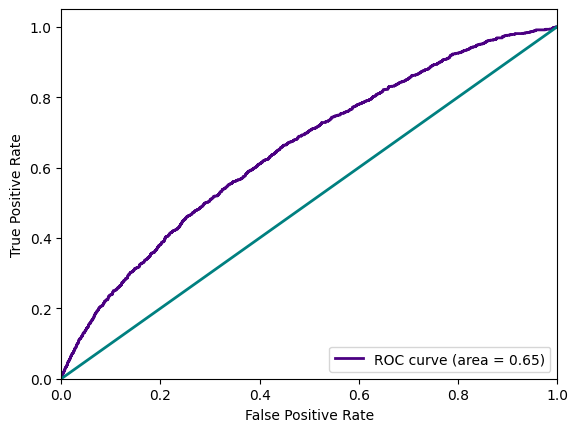

In [227]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(gt_np, pro_np)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='indigo', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='teal', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title(f'ROC Curve - ACC {acc*100}%')
plt.legend(loc="lower right")
plt.show()

In [228]:
print("F1 Score:",c[0])
print("Accuracy",c[2]*100,'%')
print("Recall:",c[1]*100,'%')
print("Loss",c[3])

F1 Score: 0.1141404153128973
Accuracy 84.10755467700652 %
Recall: 32.818846466287575 %
Loss 0.5340262323240691
